# Machine Learning Project to Classify Traffic Signs using TensorFlow¶
by Ram Rohit Gannavarapu, May 12, 2020

Automation is playing a very keen role in human life especially in the 21st century. One such field which is quickly evolving is Autonomous Cars, as of today a lot of work and research is being done on various pursuits to make automobiles more intelligent, safer and more convenient. In this project I tried to develop a Machine Learning model that would detect and classify various road signs.


**Dataset used: [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).
This dataset has more than 50,000 images of 43 classes.**



###### Basic Outline:
- **Load The Data**
- **Dataset Summary & Exploration**
- **Data Preprocessing**.
    - Shuffling.
    - Grayscaling.
    - Local Histogram Equalization.
    - Normalization.
- **Design a nueral Network Architecture.**
    - LeNet-5.
    - VGGNet.
- **Model Training and Evaluation.**
- **Testing the Model Using the Test Set.**
- **Testing the Model on New Images.**



# Step 0: Importing required Libraries

In [1]:
# Importing Python libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
# from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Activation, Flatten

# is it using the GPU?
print(tf.test.gpu_device_name())

# Show current TensorFlow version
tf.__version__

Using TensorFlow backend.


'2.1.0'

---
## Step 1: Loading The Data

The original data from the German Traffic Sign Dataset has real life images of trafffic signs. The Image sizes vary between 15x15 to 250x250 pixels and are not always in a square format. The actual traffic sign is also not necessarily centered within the image. Annotation is provided in which a bounding box arround the traffic sign are provided.


The Annotation file has the following information to extract only the traffic sign from the images.

Filename: Filename of corresponding image

Width: Width of the image

Height: Height of the image

ROI.x1: X-coordinate of top-left corner of traffic sign bounding box

ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box

ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box

ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box

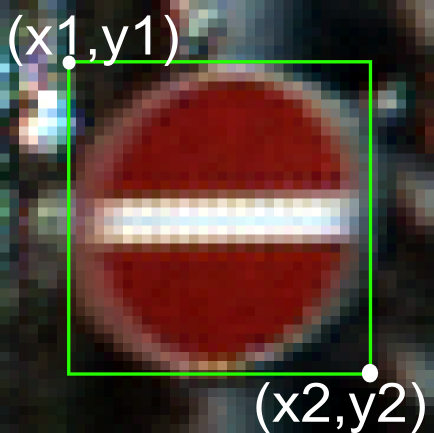


Download the dataset from [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip). This is a pickled dataset in which the images are resized to 32x32 shape.

The following three `.p` files have 32x32 resized images:
- `train.p`: The training set.
- `test.p`: The testing set.
- `valid.p`: The validation set.

We will use Python `pickle` to load the data.

In [2]:
training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [109]:
# Mapping ClassID to traffic sign names
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [108]:
# Mapping ClassID to traffic sign names
signs = {}
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    i=0
    for row in signnames:
        signs.update({i:row[1]})
        i=i+1
    csvfile.close()

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

---

## Step 2: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.



**First, we will use `numpy` provide the number of images in each subset, in addition to the image size, and the number of unique classes.**

In [4]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_validation = X_valid.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


**Then, we will use `matplotlib` plot sample images from each subset.**

In [5]:
def plot_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

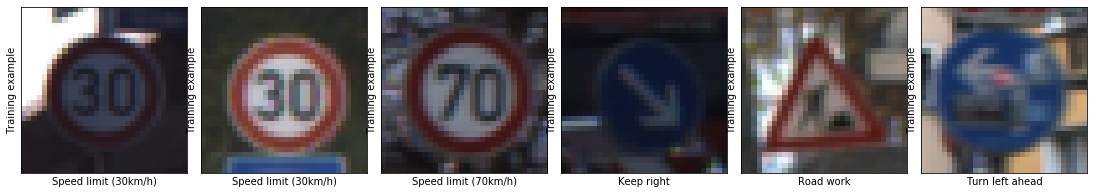

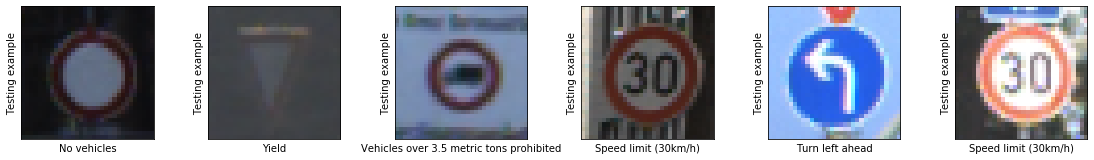

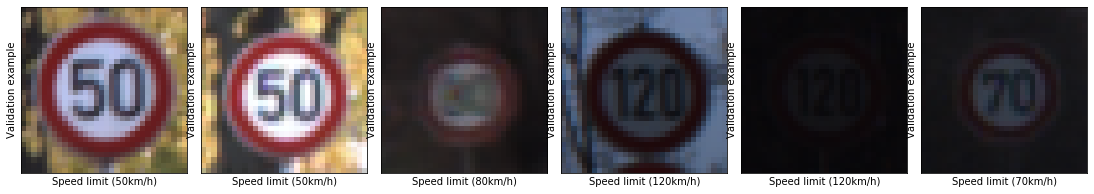

In [6]:
# Plotting sample examples
plot_images(X_train, y_train, "Training example")
plot_images(X_test, y_test, "Testing example")
plot_images(X_valid, y_valid, "Validation example")

**And finally, we will use `numpy` to plot a histogram of the count of images in each unique class.**

In [7]:
def plot_hist(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()

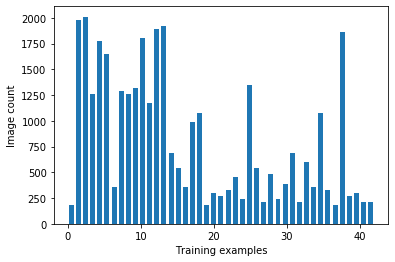

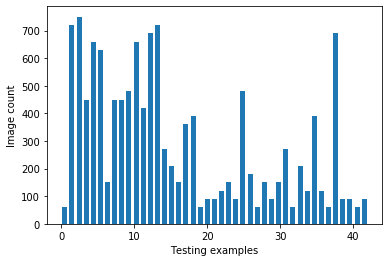

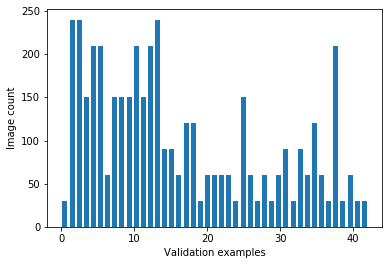

In [8]:
# Plotting histograms of the count of each sign
plot_hist(y_train, "Training examples")
plot_hist(y_test, "Testing examples")
plot_hist(y_valid, "Validation examples")

---

## Step 3: Data Preprocessing

Data preprocessing plays a vital role in Machine learning as the quality of the data directly affects the ability of a model to learn. In this step we will apply the below preprocessing steps to the input images so that our machine learning model achieves better accuracy.

**We will use the following preprocessing techniques:**
1. Shuffling.
2. Grayscaling.
3. Local Histogram Equalization.
4. Normalization.

In [98]:
def plot_f6(data):
    """
    Plot the first 6 images
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(2, 6, i+1)
    #     indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' #if len(X_train[i].shape) == 2 else cmap
        plt.imshow(data[i], cmap = cmap)
#         plt.xlabel(s"igns[i])
#         plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])    
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

1.
**Shuffling**: We shuffle the training data to increase randomness and reduce the varience and makes sures that the model remains general and doesnt overfit the data so that the model is more stable. We will use `sklearn` to shuffle our data.

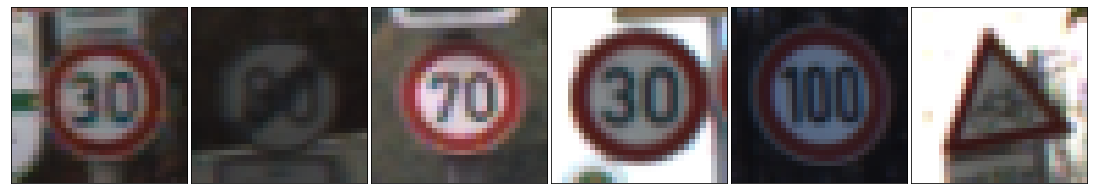

In [203]:
X_train, y_train = shuffle(X_train, y_train)
plot_f6(X_train)

2.
**Grayscaling**: In their paper ["Traffic Sign Recognition with Multi-Scale Convolutional Networks"](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) published in 2011, P. Sermanet and Y. LeCun stated that ConvNet's accuracy increases by using grayscale images instead of color images. I have used `OpenCV` to convert the training images into grey scale.

In [199]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

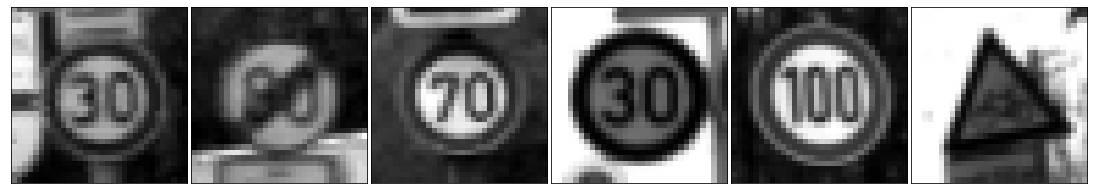

In [204]:
# Sample images after greyscaling
gray_images = list(map(gray_scale, X_train))
# plot_images(gray_images, y_train, "Gray Scale image", "gray")

plot_f6(gray_images)


3.
**Local Histogram Equalization**: This technique is a widely used image contrast enhancement method. it spreads out the most frequent intensity values in an image, which  enhances the images with low contrast. The current data set has a lot of real world images and have many images with low contrast and by applying local histogram equalization we will be able to improve the quality of the training images.

In [201]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

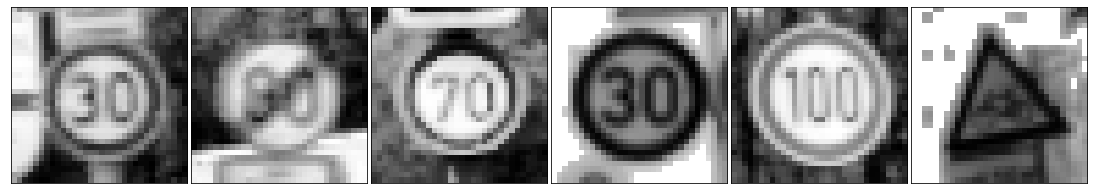

In [205]:
# Sample images after Local Histogram Equalization
equalized_images = list(map(local_histo_equalize, gray_images))
plot_f6(equalized_images)

4.
**Normalization**: Normalization is a process that changes the range of pixel intensity values. Usually the image data should be normalized so that the data has mean zero and equal variance.

In [225]:
def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

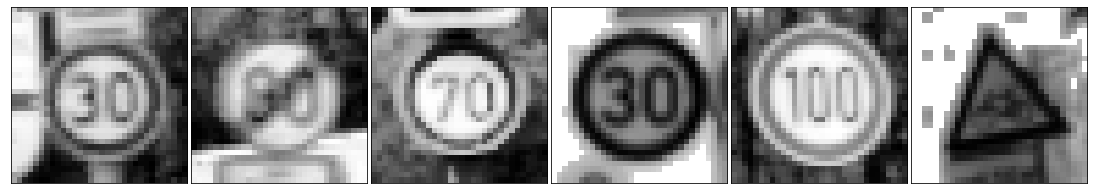

(34799, 32, 32, 1)

In [226]:
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
# list_images(normalized_images, y_train, "Normalized Image", "gray")
plot_f6(normalized_images)
normalized_images = normalized_images[..., None]
normalized_images.shape

In [36]:
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

---

## Step 3: Design a Nueral Network  Architecture

In this step, we will be designing a deep learning model that learns to recognize traffic signs from the given dataset [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

For classifying the images in this dataset we will use Convolutional Neural Networks.To recognize visual patterns directly from pixel images with minimal preprocess, we use ConvNets.At every level from data the ConvNets automatically learn hierarchies of invariant features.

Our aim is to get an accuracy of more than 95% on the given validation set and for this we will implement two of the most famous nd improtant ConvNets. 

First, I will explain the working of each network architecture and then implement the same using TensorFlow.

**Notes**:
1. We mention 0.001 as the learning rate, this will let the network know how quickly we need to update the respective weights.
2. The loss function is minimised with the help of Adaptive Moment Estimation (Adam) Algorithm. The optimization algorithm Adam was introduced by D. Kingma and J. Lei Ba in a 2015 paper named [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980). Adaptive learning rates for each parameter are calculated the Adam algorithm. In addition to storing an exponentially decaying average of past squared gradients like [Adadelta](https://arxiv.org/pdf/1212.5701.pdf) and [RMSprop](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) algorithms, the Adam optimisation algorithm also keeps a track of exponentially decaying average of past gradients mtmt, similar to that of [momentum algorithm](http://www.sciencedirect.com/science/article/pii/S0893608098001166?via%3Dihub), which helps us in turn by producing better results.
3. To update the network and minimize our training loss, we run `minimize()` function on the optimizer which uses back propagation. 

### 1.  LeNet-5
For handwritten and machine-printed character recognition they have developed a convolutional network called LeNet-5. It was introduced by the famous [Yann LeCun](https://en.wikipedia.org/wiki/Yann_LeCun) in his paper [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) in 1998. We are confident it will have a very high accuracy when dealing with traffic signs although ConvNet was originally intended to classify hand-written digits, as both hand-written digits and traffic signs are given as input to the algorithm in the form of images.

**LeNet-5 architecture:**
<figure>
 <img src="LeNet.png" width="1072" alt="Combined Image" />
 <figcaption>
 <p></p> 
 </figcaption>
</figure>

This ConvNet follows these steps:

Input => Convolution => ReLU => Pooling => Convolution => ReLU => Pooling => FullyConnected => ReLU => FullyConnected

**Layer 1 (Convolutional):** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2 (Convolutional):** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flattening:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 3 (Fully Connected):** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4 (Fully Connected):** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5 (Fully Connected):** This should have 43 outputs.

In [29]:
class LaNet:

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 28x28x6.
        self.filter1_width = 5
        self.filter1_height = 5
        self.input1_channels = 1
        self.conv1_output = 6
        # Weight and bias
        self.conv1_weight = tf.Variable(tf.random.truncated_normal(
            shape=(self.filter1_width, self.filter1_height, self.input1_channels, self.conv1_output),
            mean = self.mu, stddev = self.sigma))
        self.conv1_bias = tf.Variable(tf.zeros(self.conv1_output))
        # Apply Convolution
        self.conv1 = tf.nn.conv2d(input=x, filters=self.conv1_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv1_bias

        # Activation:
        self.conv1 = tf.nn.relu(self.conv1)

        # Pooling: Input = 28x28x6. Output = 14x14x6.
        self.conv1 = tf.nn.max_pool2d(input=self.conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Layer 2 (Convolutional): Output = 10x10x16.
        self.filter2_width = 5
        self.filter2_height = 5
        self.input2_channels = 6
        self.conv2_output = 16
        # Weight and bias
        self.conv2_weight = tf.Variable(tf.random.truncated_normal(
            shape=(self.filter2_width, self.filter2_height, self.input2_channels, self.conv2_output),
            mean = self.mu, stddev = self.sigma))
        self.conv2_bias = tf.Variable(tf.zeros(self.conv2_output))
        # Apply Convolution
        self.conv2 = tf.nn.conv2d(input=self.conv1, filters=self.conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv2_bias

        # Activation:
        self.conv2 = tf.nn.relu(self.conv2)

        # Pooling: Input = 10x10x16. Output = 5x5x16.
        self.conv2 = tf.nn.max_pool2d(input=self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Flattening: Input = 5x5x16. Output = 400.
        self.fully_connected0 = Flatten()(self.conv2)

        # Layer 3 (Fully Connected): Input = 400. Output = 120.
        self.connected1_weights = tf.Variable(tf.random.truncated_normal(shape=(400, 120), mean = self.mu, stddev = self.sigma))
        self.connected1_bias = tf.Variable(tf.zeros(120))
        self.fully_connected1 = tf.add((tf.matmul(self.fully_connected0, self.connected1_weights)), self.connected1_bias)

        # Activation:
        self.fully_connected1 = tf.nn.relu(self.fully_connected1)

        # Layer 4 (Fully Connected): Input = 120. Output = 84.
        self.connected2_weights = tf.Variable(tf.random.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        self.connected2_bias = tf.Variable(tf.zeros(84))
        self.fully_connected2 = tf.add((tf.matmul(self.fully_connected1, self.connected2_weights)), self.connected2_bias)

        # Activation.
        self.fully_connected2 = tf.nn.relu(self.fully_connected2)

        # Layer 5 (Fully Connected): Input = 84. Output = 43.
        self.output_weights = tf.Variable(tf.random.truncated_normal(shape=(84, 43), mean = self.mu, stddev = self.sigma))
        self.output_bias = tf.Variable(tf.zeros(43))
        self.logits =  tf.add((tf.matmul(self.fully_connected2, self.output_weights)), self.output_bias)

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(input_tensor=self.cross_entropy)
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(input=self.logits, axis=1), tf.argmax(input=self.one_hot_y, axis=1))
        self.accuracy_operation = tf.reduce_mean(input_tensor=tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.compat.v1.train.Saver()

    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.compat.v1.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(input=self.logits, axis=1),
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred

    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.compat.v1.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation,
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples


### 2.  VGGNet

VGGNet was proposed by K. Simonyan and A. Zisserman from the University of Oxford in 2014 [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf). VGGNet has a better accuracy and it has many successful real world implementations. 

Their main contribution from this paper was that, Evaluation of networks of increasing depth using an architecture with very small (3x3) convolution filters, which shows that a significant improvement on the previouly designed configurations can be achieved by pushing the depth to 16-19 weight layers.

**VGGNet architecture:**
<figure>
 <img src="VGGNet.png" width="1072" alt="Combined Image" />
 <figcaption>
 <p></p> 
 </figcaption>
</figure>

The original VGGNet architecture has 16-19 layers, In the current implementation we have excluded few layers and implemented a modified version with only 12 layers so that it can smoothly run on my system.

This Convolutional Network has the following layers:

Input => Convolution => ReLU => Convolution => ReLU => Pooling => Convolution => ReLU => Convolution => ReLU => Pooling => Convolution => ReLU => Convolution => ReLU => Pooling => FullyConnected => ReLU => FullyConnected => ReLU => FullyConnected

**Layer 1 (Convolutional):** The output shape would be 32x32x32.

**Activation.** Your choice of activation function.

**Layer 2 (Convolutional):** The output shape would be 32x32x32.

**Activation.** Your choice of activation function.

**Layer 3 (Pooling)** The output shape would be 16x16x32.

**Layer 4 (Convolutional):** The output shape should be 16x16x64.

**Activation.** Your choice of activation function.

**Layer 5 (Convolutional):** The output shape would be 16x16x64.

**Activation.** Your choice of activation function.

**Layer 6 (Pooling)** The output shape would be 8x8x64.

**Layer 7 (Convolutional):** The output shape would be 8x8x128.

**Activation.** Your choice of activation function.

**Layer 8 (Convolutional):** The output shape would be 8x8x128.

**Activation.** Your choice of activation function.

**Layer 9 (Pooling)** The output shape would be 4x4x128.

**Flattening:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 10 (Fully Connected):** This should have 128 outputs.

**Activation.** Your choice of activation function.

**Layer 11 (Fully Connected):** This should have 128 outputs.

**Activation.** Your choice of activation function.

**Layer 12 (Fully Connected):** This should have 43 outputs.

In [ ]:
class VGGnet:

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.random.truncated_normal(shape=(3, 3, 1, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(input=x, filters=self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2 (Convolutional): Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.random.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(input=self.conv1, filters=self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Layer 3 (Pooling): Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool2d(input=self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, 1 - (keep_prob_conv))

        # Layer 4 (Convolutional): Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.random.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(input=self.conv2, filters=self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 5 (Convolutional): Input = 16x16x64. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.random.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(input=self.conv3, filters=self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Layer 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool2d(input=self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, 1 - (keep_prob_conv)) # dropout

        # Layer 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.random.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(input=self.conv4, filters=self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.random.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(input=self.conv5, filters=self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Layer 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool2d(input=self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, 1 - (keep_prob_conv)) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = Flatten()(self.conv6)

        # Layer 10 (Fully Connected): Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.random.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, 1 - (keep_prob)) # dropout

        # Layer 11 (Fully Connected): Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.random.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, 1 - (keep_prob)) # dropout

        # Layer 12 (Fully Connected): Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.random.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(input_tensor=self.cross_entropy)
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(input=self.logits, axis=1), tf.argmax(input=self.one_hot_y, axis=1))
        self.accuracy_operation = tf.reduce_mean(input_tensor=tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.compat.v1.train.Saver()

    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.compat.v1.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(input=self.logits, axis=1),
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred

    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.compat.v1.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation,
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples


---

## Step 4: Model Training and Evaluation

In this step, we will train our model using `normalized_images`, then we'll compute softmax cross entropy between `logits` and `labels` to measure the model's error probability.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [37]:
tf.compat.v1.disable_eager_execution()
x = tf.compat.v1.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.compat.v1.placeholder(tf.int32, (None))

The `keep_prob` and `keep_prob_conv` variables will be used to control the dropout rate when training the neural network.
Overfitting is a serious problem in deep nural networks. Dropout is a technique for addressing this problem.
The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much. During training, dropout samples from an exponential number of different “thinned” networks. At test time, it is easy to approximate the effect of averaging the predictions of all these thinned networks by simply using a single unthinned network that has smaller weights. This significantly reduces overfitting and gives major improvements over other regularization methods. This technique was introduced by N. Srivastava, G. Hinton, A. Krizhevsky I. Sutskever, and R. Salakhutdinov in their paper [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

In [32]:
keep_prob = tf.compat.v1.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.compat.v1.placeholder(tf.float32)  # For convolutional layers


In [33]:
# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)

In [34]:
EPOCHS = 30
BATCH_SIZE = 64
DIR = 'Saved_Models'

Now, we'll run the training data through the training pipeline to train the model.
- Before each epoch, we'll shuffle the training set.
- After each epoch, we measure the loss and accuracy of the validation set.
- And after training, we will save the model.
- A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### LeNet Model

In [16]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [38]:

LeNet_Model = LaNet(n_out = n_classes)
model_name = "LeNet"

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_examples = len(y_train)
    print("Training ...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(LeNet_Model.training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = LeNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    LeNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")



Training ...

EPOCH 1 : Validation Accuracy = 81.315%
EPOCH 2 : Validation Accuracy = 88.617%
EPOCH 3 : Validation Accuracy = 90.476%
EPOCH 4 : Validation Accuracy = 90.499%
EPOCH 5 : Validation Accuracy = 91.338%
EPOCH 6 : Validation Accuracy = 91.859%
EPOCH 7 : Validation Accuracy = 92.812%
EPOCH 8 : Validation Accuracy = 92.721%
EPOCH 9 : Validation Accuracy = 92.676%
EPOCH 10 : Validation Accuracy = 93.311%
EPOCH 11 : Validation Accuracy = 92.358%
EPOCH 12 : Validation Accuracy = 92.245%
EPOCH 13 : Validation Accuracy = 94.308%
EPOCH 14 : Validation Accuracy = 93.084%
EPOCH 15 : Validation Accuracy = 91.723%
EPOCH 16 : Validation Accuracy = 94.059%
EPOCH 17 : Validation Accuracy = 94.036%
EPOCH 18 : Validation Accuracy = 93.651%
EPOCH 19 : Validation Accuracy = 93.379%
EPOCH 20 : Validation Accuracy = 94.059%
EPOCH 21 : Validation Accuracy = 95.261%
EPOCH 22 : Validation Accuracy = 93.719%
EPOCH 23 : Validation Accuracy = 93.810%
EPOCH 24 : Validation Accuracy = 93.356%
EPOCH 25 : 

As we can see, we've been able to reach a maximum accuracy of **95.3%** on the validation set over 30 epochs, using a learning rate of 0.001.

Now, we'll train the VGGNet model and evaluate it's accuracy.

### VGGNet Model

In [54]:
VGGNet_Model = VGGnet(n_out = n_classes)
model_name = "VGGNet"

In [46]:
# Test set preprocessing
X_test_preprocessed = preprocess(X_test)

In [66]:
EPOCHS=20
# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)
one_hot_y_valid = tf.one_hot(y_valid, 43)

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    VGGNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Training...

EPOCH 1 : Validation Accuracy = 25.374%
EPOCH 2 : Validation Accuracy = 57.800%
EPOCH 3 : Validation Accuracy = 82.472%
EPOCH 4 : Validation Accuracy = 87.846%
EPOCH 5 : Validation Accuracy = 94.195%
EPOCH 6 : Validation Accuracy = 96.122%
EPOCH 7 : Validation Accuracy = 96.531%
EPOCH 8 : Validation Accuracy = 98.231%
EPOCH 9 : Validation Accuracy = 97.800%
EPOCH 10 : Validation Accuracy = 98.141%
EPOCH 11 : Validation Accuracy = 98.163%
EPOCH 12 : Validation Accuracy = 98.753%
EPOCH 13 : Validation Accuracy = 99.048%
EPOCH 14 : Validation Accuracy = 99.070%
EPOCH 15 : Validation Accuracy = 98.798%
EPOCH 16 : Validation Accuracy = 99.070%
EPOCH 17 : Validation Accuracy = 99.138%
EPOCH 18 : Validation Accuracy = 98.844%
EPOCH 19 : Validation Accuracy = 99.161%
EPOCH 20 : Validation Accuracy = 99.365%
Model saved


Using VGGNet, we've been able to reach a maximum **validation accuracy of 99.3%**. As you can observe, the model has nearly saturated after only 10 epochs, so we can reduce the epochs to 10 and save computational resources.

We'll use this model to predict the labels of the test set.

---

## Step 5: Testing the Model using the Test Set

Now, we'll use the testing set to measure the accuracy of the model over unknown examples.

In [184]:
with tf.compat.v1.Session() as sess:
    LeNet_Model.saver.restore(sess, os.path.join(DIR, "LeNet"))
#     LeNet_Model.eval()
    y_pred = LeNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy LeNet= {:.1f}%".format(test_accuracy*100))
        
with tf.compat.v1.Session() as sess:
    VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
    y_pred = VGGNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy VGGNet= {:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from Saved_Models\LeNet
Test Accuracy LeNet= 91.7%
INFO:tensorflow:Restoring parameters from Saved_Models\VGGNet
Test Accuracy VGGNet= 97.5%


### Test Accuracy using LeNet = 91.7%
### Test Accuracy using VGGNet = 97.6%

---
# Confusion Matrix

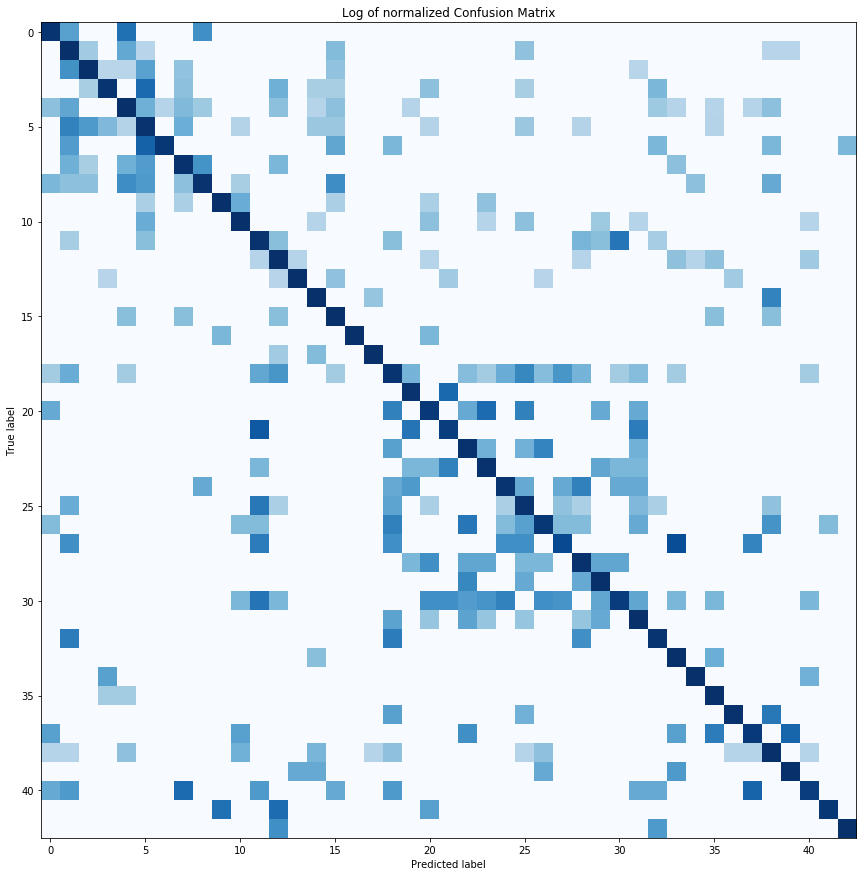

In [68]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)

plt.figure(figsize=(15, 15))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The model has some mispredictions with various speed limit signs as most have similarities in shape. The same can be observed in the confusion matrix as we see few clusters at few places. Also, traffic signs with traingular shape were misclassified among themselves. We can improve the model using hierarchical CNNs to first identify broader groups (like speed signs) and then have CNNs to classify finer features to extract speed limits.

---

## Step 6: Testing the Model on New Images

We used the above trained model to predict traffic signs type of 5 random images from the internet

In [218]:
# Loading and resizing new test images
new_test_images = []
path = './traffic-signs-data/new_test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [13, 3, 14, 27, 17,28]
print("Number of new testing examples: ", len(new_test_images))

Number of new testing examples:  6


Displaying the new testing examples, with their respective ground-truth labels:

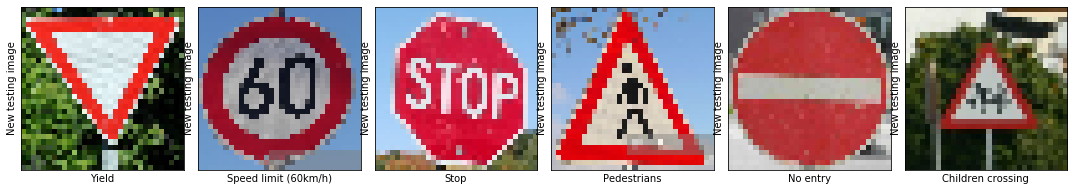

In [219]:
plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(2, 6, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=1, h_pad=0, w_pad=0)
plt.show()

In [220]:
# New test data preprocessing 
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

INFO:tensorflow:Restoring parameters from Saved_Models\VGGNet
INFO:tensorflow:Restoring parameters from Saved_Models\LeNet
New Images Test Accuracy using VGGNet = 100.0%
New Images Test Accuracy using LeNet = 80.0%


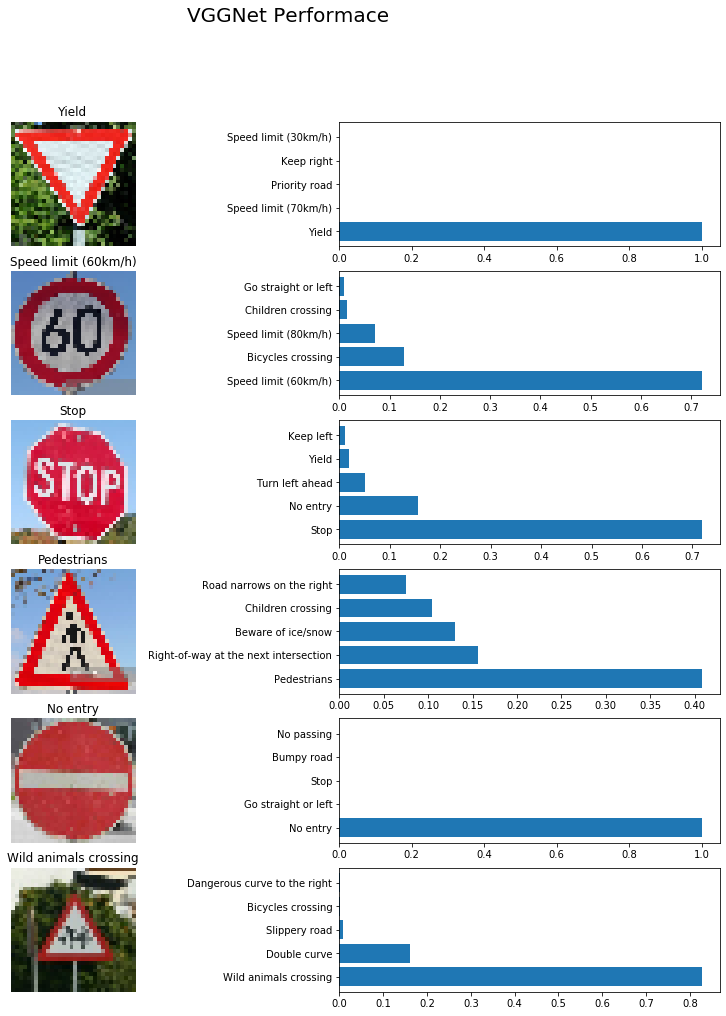

In [223]:
def y_predict_model_VGGNet(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.compat.v1.Session() as sess:
        VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

def y_predict_model_LeNet(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
   
    with tf.compat.v1.Session() as sess:
        LeNet_Model.saver.restore(sess, os.path.join(DIR, "LeNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(LeNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob_v, y_pred_v = y_predict_model_VGGNet(new_test_images_preprocessed)
y_prob_l, y_pred_l = y_predict_model_LeNet(new_test_images_preprocessed)


test_accuracy_l = 0
test_accuracy_v = 0

for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred_v[i[0]])[0]
    if accu == True:
        test_accuracy_v += 0.2
print("New Images Test Accuracy using VGGNet = {:.1f}%".format(test_accuracy_v*100))

for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred_l[i[0]])[0]
    if accu == True:
        test_accuracy_l += 0.2
print("New Images Test Accuracy using LeNet = {:.1f}%".format(test_accuracy_l*100))


plt.figure(figsize=(15, 16))
new_test_images_len=len(new_test_images_preprocessed)
# fig, axes = plt.subplots(nrows=new_test_images_len, ncols=3)
# fig.set_figheight(20)
# fig.set_figwidth(20)
# axes[0][0].set_xticks([])
# axes[0][0].set_yticks([])
# axes[0][0].imshow(new_test_images[1]) 
# i=1
# axes[0][1].barh(np.arange(1, 6, 1), y_prob_v[i, :])
# labels = [signs[j] for j in y_pred_v[i]]
# axes[0][1].tick_params(axis="y",direction="in", pad=-40)
# axes[0][0].set_yticks(np.arange(1, 6, 1))
# axes[0][1].set_yticklabels(labels)
# labels
# plt.subplot(new_test_images_len, 3, 3*i+2)
#     plt.barh(np.arange(1, 6, 1), y_prob_v[i, :])
    
#     plt.yticks(np.arange(1, 6, 1), labels) #,direction="in")
    
plt.suptitle("VGGNet Performace", fontsize=20)
    
for i in range(new_test_images_len):
    
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred_v[i][0]])
    plt.axis('off')
    
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob_v[i, :])
    labels = [signs[j] for j in y_pred_v[i]]
    plt.yticks(np.arange(1, 6, 1), labels) #,direction="in")
    
#     plt.subplot(new_test_images_len, 3, 3*i+3)
#     plt.barh(np.arange(1, 6, 1), y_prob_l[i, :])
#     labels = [signs[j] for j in y_pred_l[i]]
#     plt.yticks(np.arange(1, 6, 1), labels)#,direction="in")
plt.show()

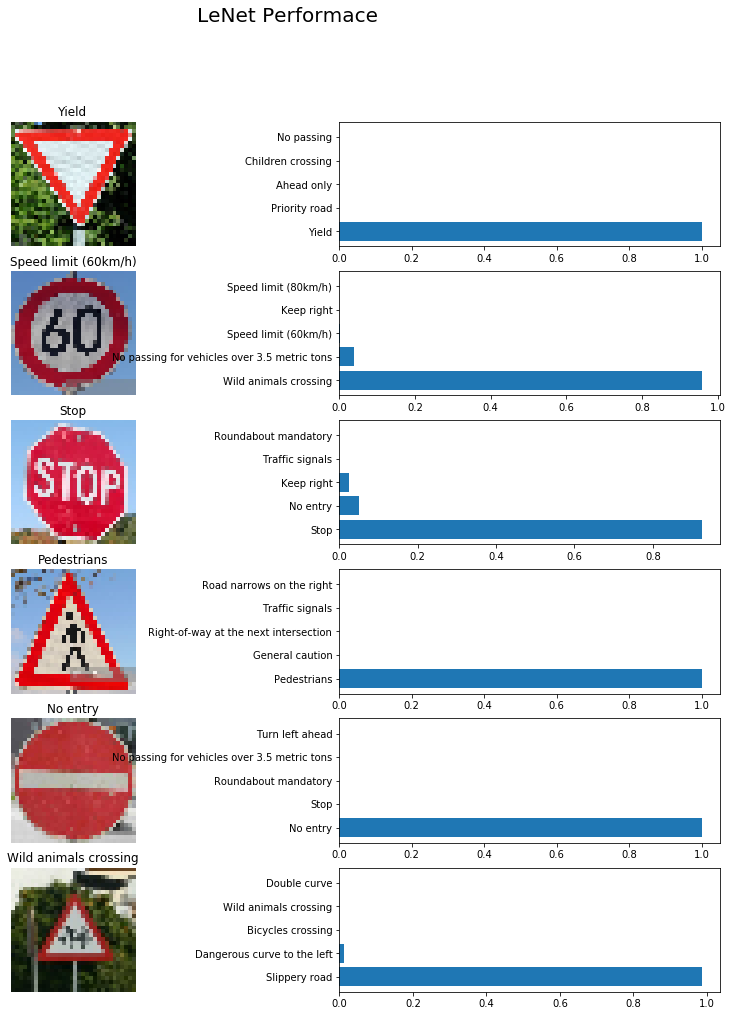

In [222]:
plt.figure(figsize=(15, 16))
plt.suptitle("LeNet Performace", fontsize=20)
for i in range(new_test_images_len):
    
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred_v[i][0]])
    plt.axis('off')
    
    plt.tick_params(axis="y",direction="in")


    
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob_l[i, :])
    labels = [signs[j] for j in y_pred_l[i]]
    plt.yticks(np.arange(1, 6, 1), labels)#,direction="in")
plt.show()

# Results

The model has a good accuracy of 100% when predicting **Yield** ,**Stop** and **No entry** signs. These signs are nearly distinct and the model has learned them quite well. On the other hand The model has some poor accuracy on the speed limit signs because various speed limits are sometimes mispredicted with other speed limits this is due to the similarities they cosesly have. There are also few cases of speed signs with triangular shape are misclassified among themselves. 


the model's performance reduces with complex triangular sign boads which have some noise in them, in the above **Pedestrian** sign image, we have a copyright symbol which is overlapping the sign board and also has a pedestrian symbol inside it, the model was able to correctly predict the true class, but with 80% confidence.


As we can observe from the above softmax probabilities, the model has very high confidence in predicting comparitively simple sign boards such as the Stop and No entry sign boards, and also has pretty decent confidence in predicting triangular sign, like the "Yield" sign.

On the other hand, in the "Speed limit" sign, we can observe that the model accurately predicted that it's a "Speed limit" sign, but has confused between the speed limits. However, it was able to correctly predict the true speed limit correctly in this case.

The VGGNet model was able to predict the right class for each of the 5 new test images. Whereas LeNet was only able to predict the 3 out of 5 images. In all cases, the VGGNet model was very certain with an accuracy between 80- 100%.


---

## Conclusion

With VGGNet, we were abele to attain a good accuracy on test images. The model also trains faster and reaches low error within 10 epochs. LeNet on the otherhand takes longer to train and also the performance is not up to the mark compared to  VGGnet. We can observe that the models reach a low error after nearly 10 epochs and saturates, We will be able to an save some computational resources if we reduce the epochs to 10. We can also try implementing other preprocessing techniques on the images to further improve the model's performance.

# References


- [Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, doi: 10.1109/5.726791](https://ieeexplore.ieee.org/document/726791)


- ["Traffic Sign Recognition with Multi-Scale Convolutional Networks"](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)
 
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

- https://github.com/udacity/self-driving-car

- https://github.com/mohamedameen93/

In [224]:
import io
from nbformat import current
import glob
nbfile = glob.glob('Gannavarapu-Project.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file Gannavarapu-Project.ipynb is 2423
